In [1]:
import requests
import json
import datetime
import hashlib
from datetime import timezone
import sqlite3
import codecs
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt

In [2]:
sqliteConnection = sqlite3.connect('Smite.db')
cursor = sqliteConnection.cursor()

# Check MMR ranges in general for KnM (all regions)

In [3]:
sql_command = """

SELECT 
    ActivePlayerId,
    Region,
    MAX(Rank_Stat_Joust) as MMR
    
    
FROM Joust_Ranked

WHERE ActivePlayerId <> 0

GROUP BY 1, 2
ORDER BY ActivePlayerId
;

"""

df = pd.read_sql_query(sql_command, sqliteConnection)
df
# cursor.execute(sql_command)

,ActivePlayerId,Region,MMR
0,456,EU,1278.26648
1,1099,NA,1479.27478
2,2108,EU,1516.01400
3,3118,EU,1366.19141
4,6695,NA,1394.88500
...,...,...,...
53399,717475942,NA,1511.14124
53400,717482291,NA,1235.74854
53401,717495675,NA,1232.73120
53402,717509566,NA,1675.23865


In [47]:
MMR_Ranges = dict()
for x in [x * 50 for x in range(0, 71)]:
    MMR_Ranges[str(x)] = (1 - len(df[df.MMR >= x])/len(df))*100

In [48]:
MMR_Ranges

{'0': 0.014787649355263444,
 '50': 0.017745179226313912,
 '100': 0.017745179226313912,
 '150': 0.02366023896841485,
 '200': 0.03253282858156625,
 '250': 0.05323553767893063,
 '300': 0.06802318703419408,
 '350': 0.10055601561576033,
 '400': 0.12125872471312471,
 '450': 0.19223944161835815,
 '500': 0.26913521826570364,
 '550': 0.37856382349461537,
 '600': 0.4879924287235271,
 '650': 0.6240388027919042,
 '700': 0.8281083638944753,
 '750': 1.073583343191764,
 '800': 1.4048266887495608,
 '850': 1.8159233408257425,
 '900': 2.342363657872948,
 '950': 3.052170826925349,
 '1000': 4.081391222051344,
 '1050': 5.220040222406242,
 '1100': 6.5864190228321355,
 '1150': 8.337276706494734,
 '1200': 10.47261327339406,
 '1250': 13.521826570448358,
 '1300': 17.27197444694192,
 '1350': 22.480184549863957,
 '1400': 28.6555069206199,
 '1450': 38.202413344374776,
 '1500': 47.08683307701408,
 '1550': 54.85922157813794,
 '1600': 61.85377972317521,
 '1650': 67.46125635868923,
 '1700': 72.0365550692062,
 '1750': 

In [49]:
MMR_data = pd.DataFrame.from_dict(MMR_Ranges, orient='index')
MMR_data

In [53]:
MMR_data.to_csv('MMR_data.csv', index=True)
df.to_csv('MMR_data_raw.csv', index=True)

im lazy so ill csv it and plot it in excel

# Now lets check what times on average are the best to Queue (MMR per ToD)

In [39]:
sql_command = """

SELECT 
    ActivePlayerId,
    SUBSTR(Entry_Datetime, 1, 9) as Date,
    SUBSTR(Entry_Datetime, 10, 12) as Time,
    CASE WHEN Rank_Stat_Joust >= 2500 THEN 1 ELSE 0 END as GM,
    CASE WHEN Rank_Stat_Joust >= 2000 THEN 1 ELSE 0 END as D,
    CASE WHEN Rank_Stat_Joust >= 1500 THEN 1 ELSE 0 END as P,
    CASE WHEN Rank_Stat_Joust < 1500 THEN 1 ELSE 0 END as Low,
    1 as game,
    Entry_Datetime,
    Rank_Stat_Joust
    
    
FROM Joust_Ranked

WHERE ActivePlayerId <> 0

ORDER BY Date, Time
;

"""

df = pd.read_sql_query(sql_command, sqliteConnection)
df

,ActivePlayerId,Date,Time,GM,D,P,Low,game,Entry_Datetime,Rank_Stat_Joust
0,6718951,4/19/2022,10:02:02 PM,0,0,1,0,1,4/19/2022 10:02:02 PM,1558.472290
1,8333632,4/19/2022,10:02:02 PM,0,0,1,0,1,4/19/2022 10:02:02 PM,1558.472290
2,9796939,4/19/2022,10:02:02 PM,0,0,1,0,1,4/19/2022 10:02:02 PM,1558.472290
3,10963633,4/19/2022,10:02:02 PM,0,0,0,1,1,4/19/2022 10:02:02 PM,814.255800
4,7705309,4/19/2022,10:02:02 PM,0,0,0,1,1,4/19/2022 10:02:02 PM,814.255800
...,...,...,...,...,...,...,...,...,...,...
299914,703170339,5/4/2022,9:48:52 AM,0,0,1,0,1,5/4/2022 9:48:52 AM,1533.335690
299915,705202520,5/4/2022,9:48:52 AM,0,0,1,0,1,5/4/2022 9:48:52 AM,1852.903930
299916,702027753,5/4/2022,9:48:52 AM,0,0,0,1,1,5/4/2022 9:48:52 AM,1097.406860
299917,700913776,5/4/2022,9:48:52 AM,0,0,1,0,1,5/4/2022 9:48:52 AM,1608.797610


In [40]:
df['Hour'] = df.Time.apply(lambda x: int(x.lstrip().split(':')[0]) + 12 if x.find('PM') > 0 else int(x.lstrip().split(':')[0]))
df

,ActivePlayerId,Date,Time,GM,D,P,Low,game,Entry_Datetime,Rank_Stat_Joust,Hour
0,6718951,4/19/2022,10:02:02 PM,0,0,1,0,1,4/19/2022 10:02:02 PM,1558.472290,22
1,8333632,4/19/2022,10:02:02 PM,0,0,1,0,1,4/19/2022 10:02:02 PM,1558.472290,22
2,9796939,4/19/2022,10:02:02 PM,0,0,1,0,1,4/19/2022 10:02:02 PM,1558.472290,22
3,10963633,4/19/2022,10:02:02 PM,0,0,0,1,1,4/19/2022 10:02:02 PM,814.255800,22
4,7705309,4/19/2022,10:02:02 PM,0,0,0,1,1,4/19/2022 10:02:02 PM,814.255800,22
...,...,...,...,...,...,...,...,...,...,...,...
299914,703170339,5/4/2022,9:48:52 AM,0,0,1,0,1,5/4/2022 9:48:52 AM,1533.335690,9
299915,705202520,5/4/2022,9:48:52 AM,0,0,1,0,1,5/4/2022 9:48:52 AM,1852.903930,9
299916,702027753,5/4/2022,9:48:52 AM,0,0,0,1,1,5/4/2022 9:48:52 AM,1097.406860,9
299917,700913776,5/4/2022,9:48:52 AM,0,0,1,0,1,5/4/2022 9:48:52 AM,1608.797610,9


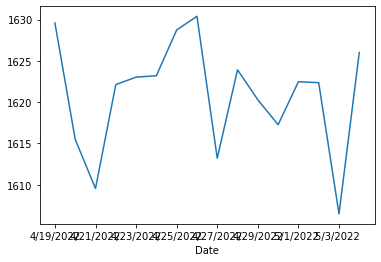

In [41]:
df.groupby(by = 'Date').mean().Rank_Stat_Joust.plot()
plt.show()

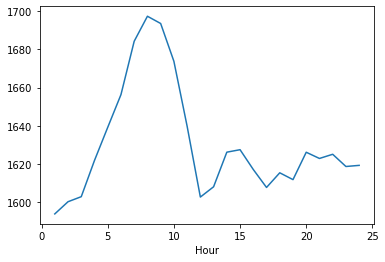

In [42]:
df.groupby(by = 'Hour').mean().Rank_Stat_Joust.plot()
plt.show()

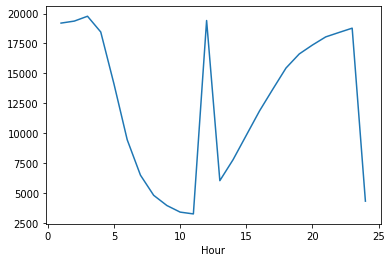

In [45]:
df.groupby(by = 'Hour').sum().game.plot()
plt.show()

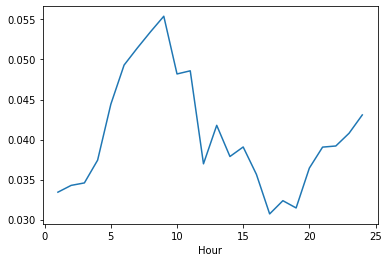

In [44]:
x = df.groupby(by = 'Hour').sum().GM/df.groupby(by = 'Hour').sum().game
x.plot()
plt.show()

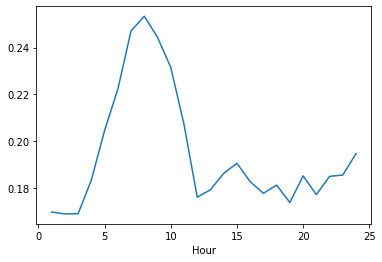

In [46]:
x = df.groupby(by = 'Hour').sum().D/df.groupby(by = 'Hour').sum().game
x.plot()
plt.show()

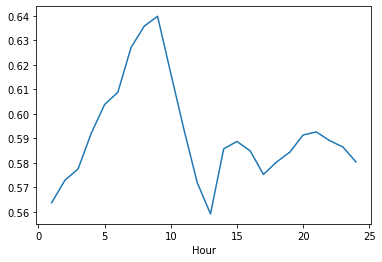

In [47]:
x = df.groupby(by = 'Hour').sum().P/df.groupby(by = 'Hour').sum().game
x.plot()
plt.show()

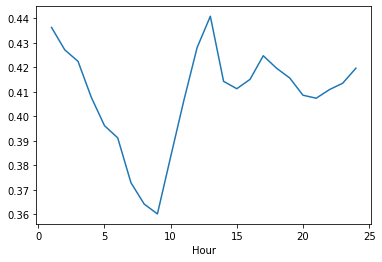

In [48]:
x = df.groupby(by = 'Hour').sum().Low/df.groupby(by = 'Hour').sum().game
x.plot()
plt.show()

# Now lets check what times on average are the best to Queue (MMR per ToD) for EU

In [68]:
sql_command = """

SELECT 
    ActivePlayerId,
    SUBSTR(Entry_Datetime, 1, 9) as Date,
    SUBSTR(Entry_Datetime, 10, 12) as Time,
    CASE WHEN Rank_Stat_Joust >= 2500 THEN 1 ELSE 0 END as GM,
    CASE WHEN Rank_Stat_Joust >= 2000 THEN 1 ELSE 0 END as D,
    CASE WHEN Rank_Stat_Joust >= 1500 THEN 1 ELSE 0 END as P,
    CASE WHEN Rank_Stat_Joust < 1500 THEN 1 ELSE 0 END as Low,
    1 as game,
    Entry_Datetime,
    Match_Duration,
    Rank_Stat_Joust
    
    
FROM Joust_Ranked

WHERE ActivePlayerId <> 0
AND Region = 'EU'

ORDER BY Date, Time
;

"""

df = pd.read_sql_query(sql_command, sqliteConnection)
df

,ActivePlayerId,Date,Time,GM,D,P,Low,game,Entry_Datetime,Match_Duration,Rank_Stat_Joust
0,6718951,4/19/2022,10:02:02 PM,0,0,1,0,1,4/19/2022 10:02:02 PM,716,1558.47229
1,8333632,4/19/2022,10:02:02 PM,0,0,1,0,1,4/19/2022 10:02:02 PM,716,1558.47229
2,9796939,4/19/2022,10:02:02 PM,0,0,1,0,1,4/19/2022 10:02:02 PM,716,1558.47229
3,10963633,4/19/2022,10:02:02 PM,0,0,0,1,1,4/19/2022 10:02:02 PM,716,814.25580
4,7705309,4/19/2022,10:02:02 PM,0,0,0,1,1,4/19/2022 10:02:02 PM,716,814.25580
...,...,...,...,...,...,...,...,...,...,...,...
56431,1383219,5/4/2022,9:44:53 AM,0,0,1,0,1,5/4/2022 9:44:53 AM,942,1800.47300
56432,701357309,5/4/2022,9:44:54 AM,0,0,1,0,1,5/4/2022 9:44:54 AM,723,1901.43933
56433,501840919,5/4/2022,9:44:54 AM,0,0,0,1,1,5/4/2022 9:44:54 AM,723,1215.74316
56434,506410194,5/4/2022,9:44:54 AM,0,0,0,1,1,5/4/2022 9:44:54 AM,723,1207.15515


In [69]:
df['Hour'] = df.Time.apply(lambda x: int(x.lstrip().split(':')[0]) + 12 if x.find('PM') > 0 else int(x.lstrip().split(':')[0]))
df

,ActivePlayerId,Date,Time,GM,D,P,Low,game,Entry_Datetime,Match_Duration,Rank_Stat_Joust,Hour
0,6718951,4/19/2022,10:02:02 PM,0,0,1,0,1,4/19/2022 10:02:02 PM,716,1558.47229,22
1,8333632,4/19/2022,10:02:02 PM,0,0,1,0,1,4/19/2022 10:02:02 PM,716,1558.47229,22
2,9796939,4/19/2022,10:02:02 PM,0,0,1,0,1,4/19/2022 10:02:02 PM,716,1558.47229,22
3,10963633,4/19/2022,10:02:02 PM,0,0,0,1,1,4/19/2022 10:02:02 PM,716,814.25580,22
4,7705309,4/19/2022,10:02:02 PM,0,0,0,1,1,4/19/2022 10:02:02 PM,716,814.25580,22
...,...,...,...,...,...,...,...,...,...,...,...,...
56431,1383219,5/4/2022,9:44:53 AM,0,0,1,0,1,5/4/2022 9:44:53 AM,942,1800.47300,9
56432,701357309,5/4/2022,9:44:54 AM,0,0,1,0,1,5/4/2022 9:44:54 AM,723,1901.43933,9
56433,501840919,5/4/2022,9:44:54 AM,0,0,0,1,1,5/4/2022 9:44:54 AM,723,1215.74316,9
56434,506410194,5/4/2022,9:44:54 AM,0,0,0,1,1,5/4/2022 9:44:54 AM,723,1207.15515,9


In [70]:
df.groupby(by = 'Entry_Datetime').sum()

,ActivePlayerId,GM,D,P,Low,game,Match_Duration,Rank_Stat_Joust,Hour
Entry_Datetime,,,,,,,,,
4/19/2022 10:02:02 PM,7794360466,0,3,13,11,24,24522,36299.79599,528
4/19/2022 10:02:21 AM,1436584699,0,2,3,1,4,3908,7136.63322,40
4/19/2022 10:06:01 PM,5332876476,1,3,6,3,9,12643,16384.73802,198
4/19/2022 10:06:02 PM,742624935,0,3,5,1,6,6258,10917.57829,132
4/19/2022 10:06:20 AM,3138569010,0,0,0,5,5,4475,5550.36215,50
...,...,...,...,...,...,...,...,...,...
5/4/2022 9:20:53 AM,773327752,0,0,7,3,10,7668,15396.87081,90
5/4/2022 9:36:52 AM,24568649,0,1,3,1,4,2432,6682.08936,36
5/4/2022 9:40:52 AM,792762667,0,1,10,1,11,9525,18651.04529,99


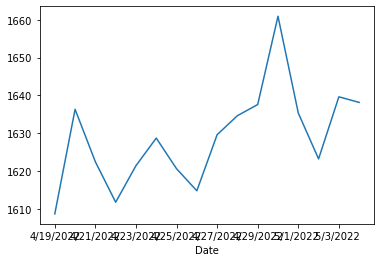

In [51]:
df.groupby(by = 'Date').mean().Rank_Stat_Joust.plot()
plt.show()

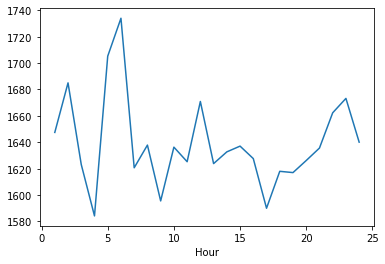

In [52]:
df.groupby(by = 'Hour').mean().Rank_Stat_Joust.plot()
plt.show()

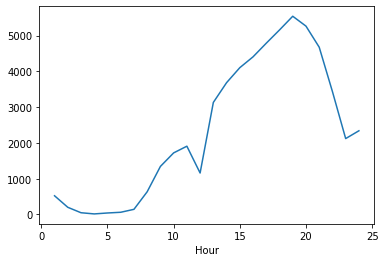

In [53]:
df.groupby(by = 'Hour').sum().game.plot()
plt.show()

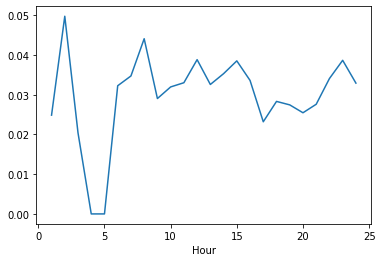

In [54]:
x = df.groupby(by = 'Hour').sum().GM/df.groupby(by = 'Hour').sum().game
x.plot()
plt.show()

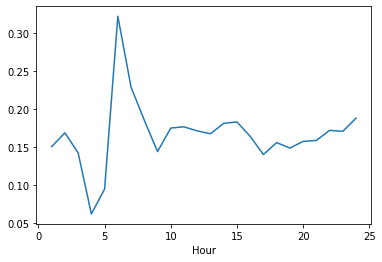

In [55]:
x = df.groupby(by = 'Hour').sum().D/df.groupby(by = 'Hour').sum().game
x.plot()
plt.show()

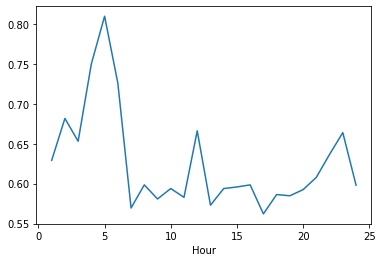

In [56]:
x = df.groupby(by = 'Hour').sum().P/df.groupby(by = 'Hour').sum().game
x.plot()
plt.show()

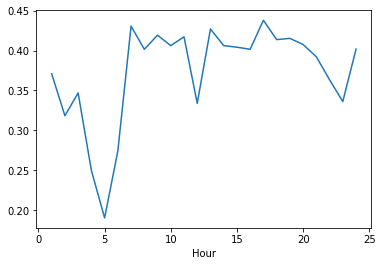

In [57]:
x = df.groupby(by = 'Hour').sum().Low/df.groupby(by = 'Hour').sum().game
x.plot()
plt.show()

In [72]:
sql_command = """

SELECT 
    Entry_Datetime,
    count(distinct match) as matchs,
    count(distinct Match_Duration) as times
    
    
FROM Joust_Ranked

WHERE ActivePlayerId <> 0
AND Region = 'EU'

GROUP BY 1
;

"""

df = pd.read_sql_query(sql_command, sqliteConnection)
df

,Entry_Datetime,matchs,times
0,4/19/2022 10:02:02 PM,4,4
1,4/19/2022 10:02:21 AM,1,1
2,4/19/2022 10:06:01 PM,2,2
3,4/19/2022 10:06:02 PM,1,1
4,4/19/2022 10:06:20 AM,1,1
...,...,...,...
4451,5/4/2022 9:20:53 AM,2,2
4452,5/4/2022 9:36:52 AM,1,1
4453,5/4/2022 9:40:52 AM,2,2
4454,5/4/2022 9:44:53 AM,1,1


## Duel

In [30]:
sql_command = """

SELECT 
    Entry_Datetime,
    A.match,
    Match_Duration,
    A.TaskForce,
    A.PartyId,
    B.Party_size,
    Avergage_MMR,
    Rank_Stat_Duel
    
    
FROM Duel_Ranked A

JOIN (SELECT match, TaskForce, AVG(Rank_Stat_Duel) as Avergage_MMR 
    FROM Duel_Ranked 
    WHERE Region = 'EU'
    AND Entry_Datetime = '4/19/2022 11:42:01 PM'
    GROUP BY 1, 2)C
ON A.match = C.match
AND A.TaskForce = C.TaskForce

JOIN (SELECT match, PartyId, count(*) as Party_size 
    FROM Duel_Ranked 
    WHERE Region = 'EU'
    AND Entry_Datetime = '4/19/2022 11:42:01 PM'
    GROUP BY 1, 2)B
ON A.PartyId = B.PartyId
AND A.Match = B.Match

WHERE Region = 'EU'
AND Entry_Datetime = '4/19/2022 11:42:01 PM'


;

"""

df = pd.read_sql_query(sql_command, sqliteConnection)
df

,Entry_Datetime,Match,Match_Duration,TaskForce,PartyId,Party_size,Avergage_MMR,Rank_Stat_Duel
0,4/19/2022 11:42:01 PM,1237880508,1287,1,296143,1,1495.57,1495.57
1,4/19/2022 11:42:01 PM,1237880508,1287,2,50425,1,1600.00,1600.00


In [28]:
sql_command = """

SELECT 
    Entry_Datetime,
    A.match,
    Match_Duration,
    A.TaskForce,
    A.PartyId,
    Rank_Stat_Duel
    
    
FROM Duel_Ranked A

WHERE SUBSTR(Entry_Datetime, 1, 9) = '4/19/2022' 
AND Region = 'EU'


;

"""

df = pd.read_sql_query(sql_command, sqliteConnection)
df

,Entry_Datetime,Match,Match_Duration,TaskForce,PartyId,Rank_Stat_Duel
0,4/19/2022 12:06:35 AM,1237651552,1059,2,6426769,1800.00000
1,4/19/2022 12:06:35 AM,1237651552,1059,1,6424528,2145.16900
2,4/19/2022 12:18:31 AM,1237653970,756,1,6329247,3500.00000
3,4/19/2022 12:18:31 AM,1237653970,756,2,6354270,2098.22852
4,4/19/2022 12:26:30 AM,1237655436,430,1,6437880,2920.82837
...,...,...,...,...,...,...
1373,4/19/2022 11:42:01 PM,1237880508,1287,1,296143,1495.57000
1374,4/19/2022 11:50:01 PM,1237882708,947,1,295080,2542.79932
1375,4/19/2022 11:50:01 PM,1237882708,947,2,239632,1834.29400
1376,4/19/2022 11:54:01 PM,1237883831,1384,1,301345,1404.41174


In [18]:
sql_command = """

SELECT 
    Entry_Datetime,
    A.match,
    Match_Duration,
    A.TaskForce,
    A.PartyId,
    B.Party_size,
    Avergage_MMR,
    Rank_Stat_Joust
    
    
FROM Joust_Ranked A

JOIN (SELECT match, TaskForce, AVG(Rank_Stat_Joust) as Avergage_MMR 
    FROM Joust_Ranked 
    WHERE ActivePlayerId <> 0
    AND Region = 'EU'
    AND Entry_Datetime = '4/19/2022 10:02:02 PM'
    GROUP BY 1, 2)C
ON A.match = C.match
AND A.TaskForce = C.TaskForce

JOIN (SELECT match, PartyId, count(*) as Party_size 
    FROM Joust_Ranked 
    WHERE ActivePlayerId <> 0
    AND Region = 'EU'
    AND Entry_Datetime = '4/19/2022 10:02:02 PM'
    GROUP BY 1, 2)B
ON A.PartyId = B.PartyId
AND A.Match = B.Match

WHERE ActivePlayerId <> 0
AND Region = 'EU'
AND Entry_Datetime = '4/19/2022 10:02:02 PM'


;

"""

df = pd.read_sql_query(sql_command, sqliteConnection)
df

,Entry_Datetime,Match,Match_Duration,TaskForce,PartyId,Party_size,Avergage_MMR,Rank_Stat_Joust
0,4/19/2022 10:02:02 PM,1237853231,1481,1,226666,3,930.167423,1027.26587
1,4/19/2022 10:02:02 PM,1237853231,1481,1,226666,3,930.167423,881.61820
2,4/19/2022 10:02:02 PM,1237853231,1481,1,226666,3,930.167423,881.61820
3,4/19/2022 10:02:02 PM,1237853231,1481,2,210732,3,1440.536130,1440.53613
4,4/19/2022 10:02:02 PM,1237853231,1481,2,210732,3,1440.536130,1440.53613
5,4/19/2022 10:02:02 PM,1237853231,1481,2,210732,3,1440.536130,1440.53613
6,4/19/2022 10:02:02 PM,1237853239,796,1,228213,3,1525.891397,1580.45715
7,4/19/2022 10:02:02 PM,1237853239,796,1,228213,3,1525.891397,1452.62671
8,4/19/2022 10:02:02 PM,1237853239,796,1,228213,3,1525.891397,1544.59033
9,4/19/2022 10:02:02 PM,1237853239,796,2,204300,1,1716.270627,1322.19482


In [12]:
sql_command = """

SELECT ActivePlayerId,
    Entry_Datetime,
    A.match,
    Match_Duration,
    A.TaskForce,
    A.PartyId,
    B.Party_size,
    Avergage_MMR,
    Rank_Stat_Conquest
    
    
FROM Conq_Ranked A

JOIN (SELECT match, TaskForce, AVG(Rank_Stat_Conquest) as Avergage_MMR 
    FROM Conq_Ranked 
    WHERE Region = 'EU'
    AND Entry_Datetime = '4/19/2022 12:08:31 AM'
    GROUP BY 1, 2)C
ON A.match = C.match
AND A.TaskForce = C.TaskForce

JOIN (SELECT match, PartyId, count(*) as Party_size 
    FROM Conq_Ranked 
    WHERE Region = 'EU'
    AND Entry_Datetime = '4/19/2022 12:08:31 AM'
    GROUP BY 1, 2)B
ON A.PartyId = B.PartyId
AND A.Match = B.Match

WHERE Region = 'EU'
AND Entry_Datetime = '4/19/2022 12:08:31 AM'

GROUP BY 1,2,3,4,5,6,7,8,9

ORDER BY A.Match, A.Taskforce
;

"""

df = pd.read_sql_query(sql_command, sqliteConnection)
df

,ActivePlayerId,Entry_Datetime,Match,Match_Duration,TaskForce,PartyId,Party_size,Avergage_MMR,Rank_Stat_Conquest
0,0,4/19/2022 12:08:31 AM,1237651858,1588,1,6394248,1,1761.804126,2080.20874
1,4794117,4/19/2022 12:08:31 AM,1237651858,1588,1,0,2,1761.804126,2123.62061
2,6984347,4/19/2022 12:08:31 AM,1237651858,1588,1,6396438,1,1761.804126,1516.91711
3,8080692,4/19/2022 12:08:31 AM,1237651858,1588,1,6384585,1,1761.804126,1435.32349
4,9827316,4/19/2022 12:08:31 AM,1237651858,1588,1,6421878,1,1761.804126,1652.95068
5,0,4/19/2022 12:08:31 AM,1237651858,1588,2,0,2,1847.716212,1711.79175
6,5151545,4/19/2022 12:08:31 AM,1237651858,1588,2,6427702,1,1847.716212,2080.24341
7,10857354,4/19/2022 12:08:31 AM,1237651858,1588,2,6408241,1,1847.716212,1652.89307
8,11511225,4/19/2022 12:08:31 AM,1237651858,1588,2,6250077,1,1847.716212,1586.33154
9,708776479,4/19/2022 12:08:31 AM,1237651858,1588,2,6426892,1,1847.716212,2207.32129
